In [1]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
from cvxpy import *
import l2distance
import visclassifier
#</GRADED>
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import linregress

import pylab
from matplotlib.animation import FuncAnimation

%matplotlib notebook

<!--announcements-->
<blockquote>
    <center>
    <img src="yinyang.png" width="400px" /></a>
    </center>
      <p><cite><center>"Just as we have two eyes and two feet,<br>
      duality is part of life."<br>
<b>--Carlos Santana</b><br>
      </center></cite></p>
</blockquote>


<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. You will be using <code>cvxpy</code>. Before we get started please read through the <a href="http://www.cvxpy.org/en/latest/tutorial/index.html">tutorial</a> of cvxpy and its quadratic programming solver.

<strong>How to submit:</strong> You can submit your code using the red <strong>Submit</strong> button above. This button will send any code below surrounded by <strong>#&lt;GRADED&gt;</strong><strong>#&lt;/GRADED&gt;</strong> tags below to the autograder, which will then run several tests over your code. By clicking on the <strong>Details</strong> dropdown next to the Submit button, you will be able to view your submission report once the autograder has completed running. This submission report contains a summary of the tests you have failed or passed, as well as a log of any errors generated by your code when we ran it.
    
Note that this may take a while depending on how long your code takes to run! Once your code is submitted you may navigate away from the page as you desire -- the most recent submission report will always be available from the Details menu.
  
<p><strong>Evaluation:</strong> Your code will be autograded for technical correctness on the assignment and accuracy on the competition. Please <em>do not</em> change the names of any provided functions or classes within the code, or you will wreak havoc on the autograder. Furthermore, <em>any code not surrounded by <strong>#&lt;GRADED&gt;</strong><strong>#&lt;/GRADED&gt;</strong> tags will not be run by the autograder</em>. However, the correctness of your implementation -- not the autograder's output -- will be the final judge of your score.  If necessary, we will review and grade assignments individually to ensure that you receive due credit for your work.
    
<strong>Academic Integrity:</strong> We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else's code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don't try. We trust you all to submit your own work only; <em>please</em> don't let us down. If you do, we will pursue the strongest consequences available to us.

<strong>Getting Help:</strong> You are not alone!  If you find yourself stuck  on something, contact the course staff for help.  Office hours, section, and the <a href="https://piazza.com/class/jzlsbn9nrzs2wf">Piazza</a> are there for your support; please use them.  If you can't make our office hours, let us know and we will schedule more.  We want these projects to be rewarding and instructional, not frustrating and demoralizing.  But, we don't know when or how to help unless you ask.

<h4> Linear classification</h4>

<p> The first assignment is to implement a linear support vector machine. Before we get started we can generate some data to see if everything is working:  
</p>

In [2]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separagle labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Currently, the code below is a placeholder example of a <code>cvxpy</code> optimization problem. You need to update the objective, the constraints and introduce new variables to output the correct hyperplane and bias. </p>

In [3]:
#<GRADED>
def primalSVM(xTr, yTr, C=10):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (n)
        C     | the SVM regularization parameter
    
    Output:
        fun   | usage: predictions=fun(xTe); predictions.shape = (n,)
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    
    ## Solution Start
    
    # dummy code: example of establishing objective and constraints, and let the solver solve it.
    w = Variable(d)
    b = Variable(1)
    xi = Variable(N, nonneg=True)
    objective = sum_squares(w) + C*sum(xi)
    constraints = [multiply(y, xTr@w + b) + xi >= 1]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()
    wout = w.value
    bout = b.value
    # End of dummy code
    
    
    ## Solution End
    
    fun = lambda x: x.dot(wout) + bout
    return fun, wout, bout
#</GRADED>

We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

In [4]:
def arrayify(x):
    """flattens and converts to numpy"""
    return np.array(x).flatten()

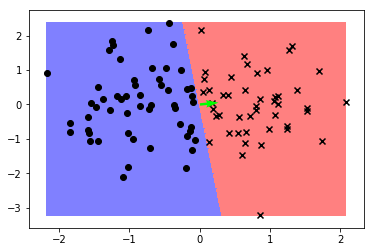

Training error: 0.0%


In [12]:
xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr,w=w,b=b)


err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

### Helper functions used to create animation

In [13]:
def updateboundary():
    global w,b,Xdata,ldata,stepsize

    _, w_pre, b_pre = primalSVM(np.transpose(Xdata),np.array(ldata),C=10)
    w = np.array(w_pre).reshape(-1)
    b = b_pre
    stepsize+=1

def updatescreen():
    global w,b,ax,line 
    q=-b/(w**2).sum()*w;
    if line==None:
        line, = ax.plot([q[0]-w[1],q[0]+w[1]],[q[1]+w[0],q[1]-w[0]],'b--')
    else:
        line.set_ydata([q[1]+w[0],q[1]-w[0]])
        line.set_xdata([q[0]-w[1],q[0]+w[1]])
    
def animate(i):
    if len(ldata)>0 and (min(ldata)+max(ldata)==0):
        if stepsize<1000:
            updateboundary()
            updatescreen();
    
def onclick(event):
    global Xdata, stepsize  
    if event.key == 'shift': # add positive point
        ax.plot(event.xdata,event.ydata,'or')
        label=1
    else: # add negative point
        ax.plot(event.xdata,event.ydata,'ob')
        label=-1    
    pos=np.array([[event.xdata],[event.ydata]])
    ldata.append(label);
    Xdata=np.hstack((Xdata,pos))
    stepsize=1;

### Animation

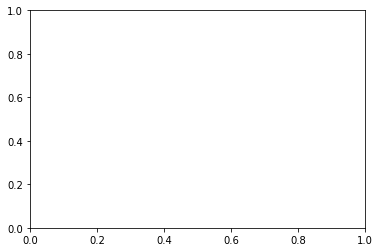

In [14]:
Xdata=pylab.rand(2,0)
ldata=[]
w=[]
b=[]
line=None
stepsize=1;
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
ani = FuncAnimation(fig, animate,pylab.arange(1,100,1),interval=10);

If the animation does not work for you, here is what it looks like.
<img src="animation.gif" width="500 px">

<h4>Spiral data set</h4>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [15]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

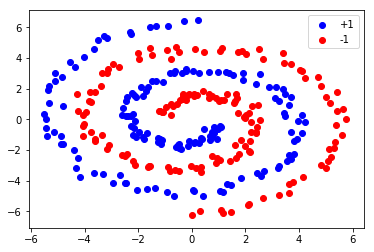

In [16]:
xTr,yTr,xTe,yTe=spiraldata()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

In [19]:
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kerneltype,X,Z,kpar)</pre>
It takes as input a kernel type (kerneltype) and two data sets $\mathbf{X}$ in $\mathcal{R}^{n\times d}$ and $\mathbf{Z}$ in $\mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>ktype='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>ktype='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed a the value of kpar)</li>
	<li>For the polynomial kernel (<code>ktype='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction.</p>





In [34]:
#<GRADED>
def computeK(kerneltype, X, Z, kpar=0.1):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    ## Solution Start
    n,d = X.shape
    m = Z.shape[0]
    if kerneltype == "linear":
        K = innerproduct(X,Z)
    if kerneltype == "rbf":
        gamma = kpar
        K = np.exp(-gamma*(l2distance.l2distance(X,Z)**2))
    if kerneltype == "polynomial":
        po = kpar
        K = (innerproduct(X,Z)+1)**po
    ## Solution End
    
    return K

def innerproduct(X,Z=None):
    if Z is None: # case when there is only one input (X)
        Z=X;
    G = np.dot(X,Z.T)
    return G

def l2distance2(X,Z=None):
    if Z is None:
        Z=X;
    n,d1=X.shape
    m,d2=Z.shape
    assert (d1==d2), "Dimensions of input vectors must match!"
    s = innerproduct(X)
    S = np.tile(np.diag(s).transpose(),(m,1)).transpose()
    r = innerproduct(Z)
    R = np.tile(np.diag(r),(n,1))
    G = innerproduct(X,Z)
    D = (S+R-2*G)
    return D
#</GRADED>

<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

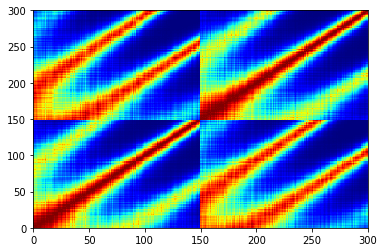

In [23]:
%matplotlib inline
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.pcolormesh(K, cmap='jet')
plt.show()
%matplotlib notebook

Remember that the SVM optimization has the following dual formulation:
$$
\begin{aligned}
             &\max_{\alpha_1,\cdots,\alpha_n}\sum_{i=1}^{n}\alpha_i - \frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij}  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
<p>Remember, the dual formulation only depends on the inner products of $\mathbf{x_i} \cdotp \mathbf{x_j}$ which can be represented by precomputed kernel entries. Implement the function <code>dualqp</code>, which takes as input a kernel matrix $K$, a vector of labels $yTr$ in $\mathcal{R}^{n}$, and a constant $C\geq 0$. This function should solve the quadratic optimization problem and output the optimal vector $\mathbf{\alpha}\in{\mathcal{R}^n}$.</p>



In [64]:
#<GRADED>
import cvxpy as cp
def dualqp(K,yTr,C):
    
    y = yTr.flatten()
    N, _ = K.shape
    
    ## Solution Start
    alpha = Variable(N,nonneg = True)
#     yy = np.outer(y,y)
    yy = np.tile(y,(N,1))
    P = abs(np.multiply(np.multiply(yy.T, yy), K))
#     P = np.sqrt(np.multiply(np.multiply(yy.T, yy), K)**2)
    objective = sum(alpha) - (1/2)*quad_form(alpha, P)
    constraints = [alpha <= C, sum(multiply(y, alpha)) == 0]
    prob = Problem(Maximize(objective), constraints)
    prob.solve()
    
#     yy = np.outer(y,y)
#     alsq = np.outer(alpha,alpha)
#     objective = sum(alpha) - 1/2*(multiply(multiply(alsq, yy),K))
#     constraints = [alpha <= C, sum(multiply(y, alpha)) == 0]
#     prob = Problem(Maximize(objective), constraints)
#     prob.solve()
    ## Solution End
    
    return np.array(alpha.value).flatten()
#</GRADED>

The following code shows a usecase of how <code>dualqp</code> could be used in practice. 

In [65]:
C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel (make sure it is PSD)
K = computeK(ktype,xTr,xTr,lmbda)

alpha=dualqp(K,yTr,C)
# print(alpha)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var4688, abs([[ 1.00000000e+00  9.90232871e-01  9.71423330e-01 ... -5.61420387e-04
  -2.91523821e-04 -1.24395349e-04]
 [ 9.90232871e-01  1.00000000e+00  9.30485309e-01 ... -5.34222439e-04
  -2.78872137e-04 -1.10841869e-04]
 [ 9.71423330e-01  9.30485309e-01  1.00000000e+00 ... -6.83972873e-04
  -3.54449378e-04 -1.71594557e-04]
 ...
 [-5.61420387e-04 -5.34222439e-04 -6.83972873e-04 ...  1.00000000e+00
   9.85160951e-01  8.52603350e-01]
 [-2.91523821e-04 -2.78872137e-04 -3.54449378e-04 ...  9.85160951e-01
   1.00000000e+00  8.70214438e-01]
 [-1.24395349e-04 -1.10841869e-04 -1.71594557e-04 ...  8.52603350e-01
   8.70214438e-01  1.00000000e+00]]))

<p> Now that you can solve the dual correctly, you should have the values for $\alpha_i$. But you are not done yet. You still need to be able to classify new test points. Remember from class that $h(\mathbf{x})=\sum_{i=1}^n \alpha_i y_i k(\mathbf{x}_i,\mathbf{x})+b$. You need to obtain the bias term $b$. It is easy to show (and omitted here) that if $C>\alpha_i>0$ (with strict $>$), then we must have that $y_i(\sum_{i=1}^n \alpha_i y_i k(\mathbf{x}_i,\mathbf{x})+b)=1$. Rephrase this equality in terms of $\alpha_i$ and solve for $b$. Implement

<p> b=recoverBias(K,yTr,alphas,C); </p>

<p> where <code>b</code> is the hyperplane bias.
(Hint: This is most stable if you pick an $\alpha_i$ that is furthest from $C$ and $0$. )</p>

<p>Please note that this use of the word bias has absolutely nothing to do with the word bias in the bias variance trade-off. It is just the same word but two completely different meanings. This unfortunate term collision comes from the fact that we are borrowing concepts from geometry and statistics.</p>

In [61]:
#<GRADED>
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : nx1 input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """

    ## Solution Start
    idx = (np.abs(alpha-C/2.0)).argmin()
    bias=(1/yTr[idx])-np.multiply(alpha,yTr).dot(K[:,idx])
    ## Solution End
    
    return bias
#</GRADED>

<p> Test your <b><code>recoverBias</code></b> function with the following code, which uses the dual solver on a linearly separable dataset:</p>

In [63]:
%matplotlib inline
xTr,yTr=genrandomdata(b=0.5)
C=10
K=computeK("linear",xTr,xTr)
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
wa = (alpha * yTr).dot(xTr)
fun = lambda x: x.dot(wa) + ba
visclassifier.visclassifier(fun, xTr, yTr, w=wa, b=ba)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var4672, [[1.08447186e+00 2.95098948e+00 3.82681826e-02 ... 5.14523477e-01
  8.95959779e-02 3.93542187e-01]
 [2.95098948e+00 9.77918311e+00 8.20709951e-01 ... 3.63932450e+00
  6.06030639e-01 1.14961695e+00]
 [3.82681826e-02 8.20709951e-01 2.94910855e-01 ... 9.35506077e-01
  3.44989800e-01 4.61434152e-02]
 ...
 [5.14523477e-01 3.63932450e+00 9.35506077e-01 ... 3.11074899e+00
  1.04543316e+00 2.87512704e-01]
 [8.95959779e-02 6.06030639e-01 3.44989800e-01 ... 1.04543316e+00
  4.20296322e-01 5.74143912e-03]
 [3.93542187e-01 1.14961695e+00 4.61434152e-02 ... 2.87512704e-01
  5.74143912e-03 1.46356186e-01]])

<p>
    Implement the function 
    <pre>
    svmclassify=dualSVM(xTr,yTr,C,ktype,kpar);
    </pre>
    It should use your functions <code><b>computeK</b></code> and <code><b>generateQP</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>, to be used as kpar in Kernel construction). Then, find the support vectors and recover the bias to return <b><code>svmclassify</code></b>, a function that uses your SVM to classify a set of test points <code>xTe</code>.

    
</p>


In [49]:
#<GRADED>
def dualSVM(xTr,yTr,C,ktype,lmbda):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
        ktype | the type of kernelization: 'rbf','polynomial','linear'
        lmbda | the kernel parameter - degree for poly, inverse width for rbf
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    
    # Solution Start
    K=computeK(ktype,xTr,xTr,kpar=lmbda)
    alpha = dualqp(K,yTr,C)
    ba=recoverBias(K,yTr,alpha,C)
    wa = (alpha * yTr)
    svmclassify = lambda x: wa.dot(computeK(ktype,xTr,x,kpar=lmbda)) + ba
    # Solution End
    
    return svmclassify
#</GRADED>

<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

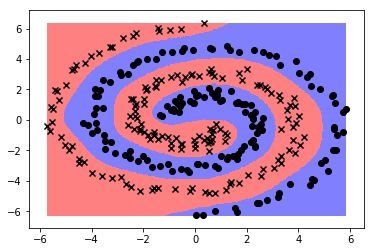

Training error: 0.0000
Testing error: 0.0033


In [50]:
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=0.25
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)


visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

SVMs are pretty sensitive to hyper-parameters. We can visualize the results of a hyper-parameter grid search as a heat-map, where we sweep across different values of C and kpar and output the result on a validation dataset. Now we ask you to implement a cross-validation function.

In [51]:
#<GRADED>
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    
    # Start Solution
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    
    # Start Solution
    bestTestErr = 1.0
    for i, C in enumerate(CList):
        for j, lmbda in enumerate(lmbdaList):
            svmclassify = dualSVM(xTr,yTr,C,ktype,lmbda)
            preds = svmclassify(xValid)
            testingerr = np.mean(np.sign(preds)!=yValid)
            ErrorMatrix[i,j] = testingerr
    ind = np.unravel_index(np.argmin(ErrorMatrix, axis=None), ErrorMatrix.shape)
    bestC = CList[ind[0]]
    bestLmbda = lmbdaList[ind[1]]
    # End Solution
            
    return bestC,bestLmbda,ErrorMatrix
#</GRADED>

Text(0.5, 1.0, 'Validation error')

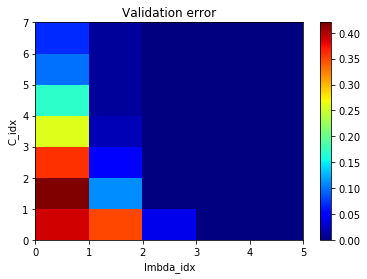

In [52]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))
bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)

plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error")

If you implemented everything correctly, the result should look similar to this image:
<center>
 <img src="crossval.png" width="300px" />
</center>

# Competition: XOR (5 points)

We ask you to implement function <code><b>competitionsvm</b></code>, which given the training set returns a lambda function that takes in a hidden test set to classify. Some things you should consider for your implementation:

- Split the given data into training set and validation set
- Consider trying both primal and dual SVM
- Implement a hyperparameter search to find optimal hyperparameter(s)

You have a 5 minute time limit on the dataset, and you should strive for a good method of finding hyperparameters (within the time limit).

You will get credit for the competition if you can beat the base benchmark of 62% accuracy.

In [ ]:
#<GRADED>
from sklearn.utils import shuffle
def competitionsvm(xTr,yTr):
    """
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (n)
    
    Output:
        func   | usage: predictions=func(xTe); predictions.shape = (n,)
        
    NOTE: This is how we will use your competitionsvm function to test
    svmclassify = competitionsvm(xTr, yTr)
    final_predictions = svmclassify(xTe)    
    """
    # Solution Start
    
    # Solution End
#</GRADED>

In [ ]:
xTr = np.genfromtxt('../resource/lib/publicdata/XOR_xTr.txt', delimiter=",")[:,:-1]
yTr = np.genfromtxt('../resource/lib/publicdata/XOR_yTr.txt', delimiter=",")[:,:-1].flatten()